In [1]:
import pandas as pd
import numpy as np
import os
import re
import time
import datetime
import gc
import string
import re
import seaborn as sns 
import matplotlib.pyplot as plt 
import math

from decimal import Decimal, getcontext

# --------------------------------------------

output_dir = r"E:\Cristian\1. Molecular Dinamics\2. Python Projects\3. Jupiter Code\15. Paper Simulations\1. LG Thermostat\1. Two_Disk_Variable_Charge\1. T_0.25\4. C1_1.0_C2_-0.5"

# Construir las rutas de los archivos basadas en output_dir
particle_data_file = os.path.join(output_dir, "Particle_Data.csv")
system_data_file = os.path.join(output_dir, "System_Data.csv")

Partic_DF = pd.read_csv(particle_data_file)
System_DF = pd.read_csv(system_data_file)

# --------------------------------------------

simulation_data_file = os.path.join(output_dir, "Simulation_Values.csv")

Simulation_Values = pd.read_csv(simulation_data_file)

Q_p = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'Q_p', 'Valor'].iloc[0])
Q_n = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'Q_n', 'Valor'].iloc[0])
m = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'm', 'Valor'].iloc[0])
N = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'N', 'Valor'].iloc[0])
kB = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'kB', 'Valor'].iloc[0])
Temp_Target = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'Temp_Target', 'Valor'].iloc[0])
e0 = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'e0', 'Valor'].iloc[0])
R = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'R', 'Valor'].iloc[0])


r_2 = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'r_2', 'Valor'].iloc[0])
r_1 = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'r_1', 'Valor'].iloc[0])
r_G = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'r_G', 'Valor'].iloc[0])
Mass = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'm', 'Valor'].iloc[0])
IDEAL = bool(Simulation_Values.loc[Simulation_Values['Variable'] == 'IDEAL', 'Valor'].iloc[0])

Save_Step = int(Simulation_Values.loc[Simulation_Values['Variable'] == 'Saving_Steps', 'Valor'].iloc[0])

Step_int = 100
Step_max = 750

Lim_Inf = Save_Step * Step_int
Lim_Sup = Save_Step * Step_max

Step_Scale = (Step_max-Step_int)+1


In [2]:
Partic_DF = Partic_DF[(Partic_DF['Step'] >= Lim_Inf) & (Partic_DF['Step'] <= Lim_Sup)]
System_DF = System_DF[(System_DF['Step'] >= Lim_Inf) & (System_DF['Step'] <= Lim_Sup)]

In [3]:
def obtener_columnas_object(dataframe):
    columnas_object = []
    tipos_datos = dataframe.dtypes
    for columna, tipo in tipos_datos.items():
        if tipo == 'object':
            columnas_object.append(columna)
    return columnas_object

# -------- Conversión de data types y alistamiento de dataframes originales --------

columns_to_convert = obtener_columnas_object(System_DF)
# print(columns_to_convert)
System_DF[columns_to_convert] = System_DF[columns_to_convert].replace(',', '.', regex=True)
System_DF[columns_to_convert] = System_DF[columns_to_convert].astype(float)
# print(System_DF.dtypes)

columns_to_convert = obtener_columnas_object(Partic_DF)
# print(columns_to_convert)
Partic_DF[columns_to_convert] = Partic_DF[columns_to_convert].replace(',', '.', regex=True)
Partic_DF[columns_to_convert] = Partic_DF[columns_to_convert].astype(float)
# print(Partic_DF.dtypes)

del columns_to_convert

In [4]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Obtener las posiciones X, Y del DataFrame
# x = Partic_DF["X_Pos"]
# y = Partic_DF["Y_Pos"]

# # Calcular las distancias desde el origen
# distancias = np.sqrt(x**2 + y**2)

# # Crear máscaras para seleccionar los puntos correspondientes a cada zona
# mask_interna = distancias <= r_1
# mask_externa = np.logical_and(distancias > r_G, distancias <= r_2)

# # Obtener las coordenadas correspondientes a cada zona
# x_interna = x[mask_interna]
# y_interna = y[mask_interna]
# x_externa = x[mask_externa]
# y_externa = y[mask_externa]

# # Crear una malla para la zona interna
# bins_interna = 25  # Ajusta el número de bins según tus necesidades
# counts_interna, x_edges_interna, y_edges_interna = np.histogram2d(x_interna, y_interna, bins=bins_interna)
# X_interna, Y_interna = np.meshgrid(x_edges_interna[:-1], y_edges_interna[:-1])
# Z_interna = counts_interna.T

# # Crear una malla para la zona externa
# bins_externa = 25  # Ajusta el número de bins según tus necesidades
# counts_externa, x_edges_externa, y_edges_externa = np.histogram2d(x_externa, y_externa, bins=bins_externa)
# X_externa, Y_externa = np.meshgrid(x_edges_externa[:-1], y_edges_externa[:-1])
# Z_externa = counts_externa.T

# # Crear la figura y los gráficos 3D
# fig1 = plt.figure(figsize=(5, 5))
# fig2 = plt.figure(figsize=(5, 5))

# # Graficar la zona interna
# ax_interna = fig1.add_subplot(111, projection='3d')
# ax_interna.plot_surface(X_interna, Y_interna, Z_interna, cmap='viridis')
# ax_interna.set_title('Zona interna')
# ax_interna.set_xlabel('Posición X')
# ax_interna.set_ylabel('Posición Y')
# ax_interna.set_zlabel('Conteo')

# # Guardar la figura 1
# fig1.savefig(os.path.join(output_dir, "3D_Charge_Dist1.png"))

# # Mostrar el gráfico 3D de la zona interna
# plt.show()

# # Graficar la zona externa
# ax_externa = fig2.add_subplot(111, projection='3d')
# ax_externa.plot_surface(X_externa, Y_externa, Z_externa, cmap='viridis')
# ax_externa.set_title('Zona externa')
# ax_externa.set_xlabel('Posición X')
# ax_externa.set_ylabel('Posición Y')
# ax_externa.set_zlabel('Conteo')

# # Guardar la figura 2
# fig2.savefig(os.path.join(output_dir, "3D_Charge_Dist2.png"))


# del fig1,fig2,x,y,distancias,mask_externa,mask_interna
# del x_interna,y_interna,x_externa,y_externa,bins_interna,counts_interna, x_edges_interna, y_edges_interna,X_interna
# del Y_interna,Z_interna,ax_interna,ax_externa
# del bins_externa,counts_externa, x_edges_externa, y_edges_externa, X_externa, Y_externa, Z_externa

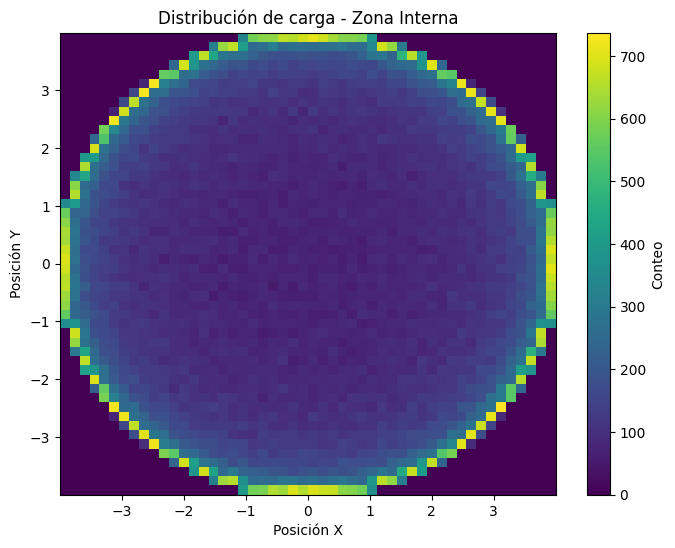

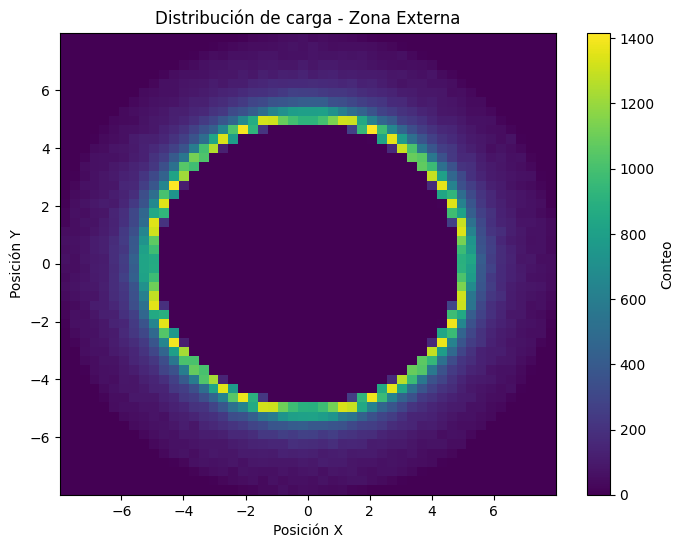

In [5]:
def graficar_zona(Partic_DF, r_1, r_2, bins, zona, name):
    # Obtener las posiciones X, Y del DataFrame
    x = Partic_DF["X_Pos"]
    y = Partic_DF["Y_Pos"]

    # Calcular las distancias desde el origen
    distancias = np.sqrt(x**2 + y**2)

    # Crear máscaras para seleccionar los puntos correspondientes a cada zona
    mask_interna = distancias <= r_1
    mask_externa = np.logical_and(distancias > r_G, distancias <= r_2)

    # Obtener las coordenadas correspondientes a la zona seleccionada
    if zona == "interna":
        x_zona = x[mask_interna]
        y_zona = y[mask_interna]
    elif zona == "externa":
        x_zona = x[mask_externa]
        y_zona = y[mask_externa]
    else:
        raise ValueError("La zona debe ser 'interna' o 'externa'.")

    # Crear el gráfico de la zona seleccionada
    plt.figure(figsize=(8, 6))
    plt.hist2d(x_zona, y_zona, bins=bins, cmap='viridis')
    plt.colorbar(label='Conteo')
    plt.title(f"Distribución de carga - Zona {zona.capitalize()}")
    plt.xlabel('Posición X')
    plt.ylabel('Posición Y')

    plt.savefig(os.path.join(output_dir, name))
    
    # Mostrar el gráfico
    plt.show()
    
graficar_zona(Partic_DF, r_1, r_2, 50, "interna", "2D_Int_Charge_Dist.png")
graficar_zona(Partic_DF, r_1, r_2, 50, "externa", "2D_Ext_Charge_Dist.png")


In [6]:
from numpy import linalg as LA

# Calcula la suma de 'Ke_Energy' para cada valor único en 'Step'
grouped_sum = Partic_DF.groupby('Step')['Ke_Energy'].sum()

# Asigna la suma correspondiente a cada fila en 'Calo_Cap'
Partic_DF['Ke_Total'] = Partic_DF['Step'].map(grouped_sum)

Partic_DF['Ke_Mean'] = Partic_DF['Vel_M']**2
Partic_DF['Ke_Mean'] = Partic_DF.groupby('Step')['Ke_Mean'].transform('mean')
Partic_DF['Ke_Mean'] = Partic_DF['Ke_Mean']*m*0.5


def magnitude(vector) : 
    return LA.norm(vector)

def q(n) : 
    if n < N/2: 
      return Q_p # n will start at zero
    else : 
      return Q_n

def Potencial_Energy(df):
    # N = len(df)  # Obtener el número de filas en el DataFrame
    rVector = df[['X_Pos', 'Y_Pos']].values  # Obtener los valores de las columnas 'x' y 'y' como una matriz numpy
    Conts = 1 / (4 * np.pi * e0)
    Sum_m = 0
    
    for m in range(0, N):
        Qm = q(m)
        Sum_n = 0
        
        for n in range(0, N):
            if m != n:
                Qn = q(n)
                Dist = magnitude(rVector[n] - rVector[m])
                Sum_n += Qn * Conts * (1 / Dist)
      
        Sum_m += Qm * Sum_n
    
    return Sum_m

def Potencial_Energy_2(df):
    N = len(df)
    rMatrix = df[['X_Pos', 'Y_Pos']].values
    
    Q = np.vectorize(q)(np.arange(N))  # Vectorized q(n) function
    Q_matrix = np.tile(Q, (N, 1))
    
    r_diff = rMatrix[:, np.newaxis, :] - rMatrix[np.newaxis, :, :]
    distances = LA.norm(r_diff, axis=-1)
    
    np.fill_diagonal(distances, 1.0)  # Avoid division by zero on the diagonal
    
    Conts = 1 / (4 * np.pi * e0)
    potential_matrix = Q_matrix * Q_matrix.T * Conts / distances
    np.fill_diagonal(potential_matrix, 0)
    
    potential_energy = np.sum(potential_matrix)
    
    return potential_energy

grouped = Partic_DF.groupby('Step')

for step, group in grouped:
    Pot_Energy = Potencial_Energy_2(group)
    Partic_DF.loc[group.index, 'Pot_Energy'] = Pot_Energy
    
    # Pot_Energy_2 = Potencial_Energy_2(group)
    # Partic_DF.loc[group.index, 'Pot_Energy_2'] = Pot_Energy_2
    
    print((step/System_DF['Step'].max())*100)


# Realizar la fusión (merge) de los DataFrames basándote en la columna 'Step'
Partic_DF = pd.merge(Partic_DF, System_DF[['Step', 'Temp_Tar']], on='Step', how='left')
Partic_DF = pd.merge(Partic_DF, System_DF[['Step', 'Temp_Act']], on='Step', how='left')

Partic_DF['Total_E'] = Partic_DF['Ke_Total'] + Partic_DF['Pot_Energy']
Partic_DF['Total_EE'] = Partic_DF['Total_E']**2

del grouped,step,group,grouped_sum,Pot_Energy


13.333333333333334
13.466666666666665
13.600000000000001
13.733333333333334
13.866666666666665
14.000000000000002
14.133333333333335
14.266666666666666
14.399999999999999
14.533333333333335
14.666666666666666
14.799999999999999
14.933333333333335
15.066666666666666
15.2
15.333333333333332
15.466666666666667
15.6
15.733333333333333
15.866666666666667
16.0
16.133333333333333
16.266666666666666
16.400000000000002
16.53333333333333
16.666666666666664
16.8
16.933333333333334
17.066666666666666
17.2
17.333333333333336
17.466666666666665
17.599999999999998
17.733333333333334
17.866666666666667
18.0
18.133333333333333
18.266666666666666
18.4
18.53333333333333
18.666666666666668
18.8
18.933333333333334
19.066666666666666
19.2
19.333333333333332
19.466666666666665
19.6
19.733333333333334
19.866666666666667
20.0
20.133333333333333
20.266666666666666
20.4
20.533333333333335
20.666666666666668
20.8
20.933333333333334
21.066666666666666
21.2
21.333333333333336
21.46666666666667
21.6
21.7333333333333

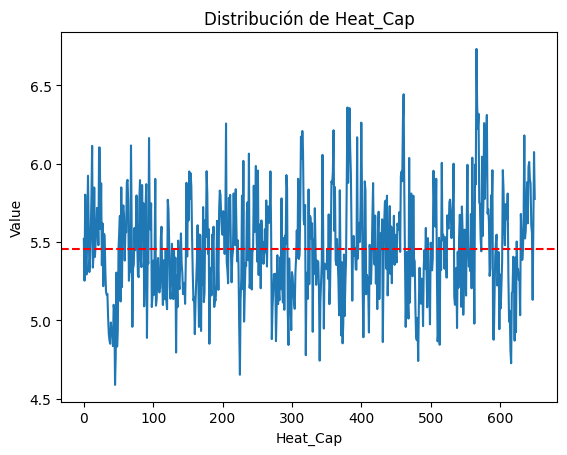

5.456545499803445


In [7]:
Partic_DF['Heat_Cap'] =  (1/(kB*(Partic_DF['Temp_Act']**2))) * (Partic_DF['Total_EE'].mean() - ((Partic_DF['Total_E'].mean())**2))
Partic_DF['Heat_Cap'] = Partic_DF['Heat_Cap']/Step_Scale

def Plot_Dist (df,colum,line_value,name):

    # Group the DataFrame by the 'Steps' column
    grouped_df = df.groupby('Step')

    # Extract the unique values of the 'Value' column
    unique_values = grouped_df[colum].unique()
    
    plt.close("all") #this is the line to be added
    num_steps = len(unique_values)
    plt.plot(range(num_steps), unique_values)
    plt.xlabel('Heat_Cap')
    plt.ylabel('Value')
    plt.title('Distribución de Heat_Cap')
    # plt.savefig(os.path.join(output_dir, "Vy_Mean_Distribution.png"))
    plt.axhline(y=line_value, color='red', linestyle='--')
    plt.savefig(os.path.join(output_dir, name))
    plt.show()
    
Plot_Dist(Partic_DF,'Heat_Cap',Partic_DF['Heat_Cap'].mean(),"Heat_Cap_Dist.png")
print(Partic_DF['Heat_Cap'].mean())

In [8]:
Partic_DF["Pos_Ratio"] = np.sqrt((Partic_DF['X_Pos']**2) + (Partic_DF['Y_Pos']**2))

325499
4.000492510291295


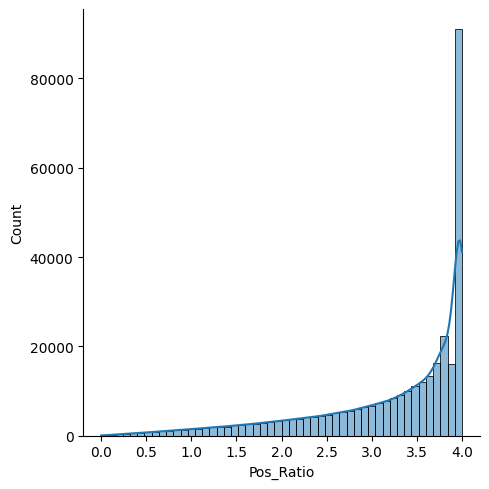

In [9]:
# ----------------------- Densidad de Carga en la Placa Interna -----------------------

Int_Density = Partic_DF[Partic_DF['Particle'] <= N/2]

Muestras = 50  # Número de muestras

# Calcular el tamaño de cada intervalo
interval_size = r_1 / Muestras

# Crear una lista de diccionarios para almacenar los resultados
resultados = []

# Calcular el rango de valores para cada intervalo y almacenarlos en la lista de resultados
for i in range(Muestras):
    inicio = i * interval_size
    fin = (i + 1) * interval_size
    resultados.append({'Intervalo': f'({inicio}, {fin})', 'Inicio': inicio, 'Fin': fin})

# Crear el DataFrame a partir de la lista de resultados
Density_Int_Info = pd.DataFrame(resultados)

# Crear una lista para almacenar los contadores de densidad de carga
densidad_carga = [0] * Muestras

# Iterar sobre cada valor en la columna Pos_Ratio de Particle_DF
for valor in Int_Density['Pos_Ratio']:
    # Verificar en qué intervalo se encuentra el valor
    for i in range(Muestras):
        inicio = i * interval_size
        fin = (i + 1) * interval_size
        if inicio <= valor < fin:
            # Incrementar el contador correspondiente al intervalo
            densidad_carga[i] += 1
            break  # Romper el bucle una vez que se ha encontrado el intervalo

# Crear una columna "Densidad_Carga" en el DataFrame df_resultados
Density_Int_Info['Count'] = densidad_carga

print(sum(Density_Int_Info['Count']))

# sns.displot(Density_Int_Info, x="Densidad_Carga",bins=Muestras, kde=True)
sns.displot(Int_Density , x="Pos_Ratio",bins=Muestras, kde=True)
print(Int_Density ["Pos_Ratio"].max())
plt.savefig(os.path.join(output_dir, "Ratial_Dist_Int.png"))


del Int_Density,Muestras,interval_size,resultados,i,inicio,fin,densidad_carga,valor

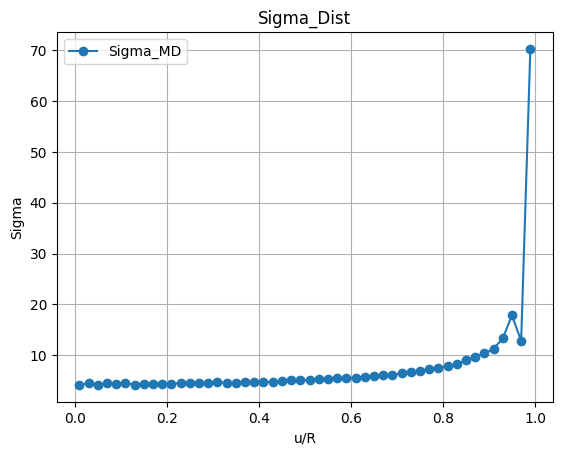

In [10]:
# Robert_Data=pd.read_csv(r"E:\Cristian\1. Molecular Dinamics\2. Python Projects\3. Jupiter Code\91. SigmaOneSheets.dat", sep='\t')

Density_Int_Info['u/R'] = ((Density_Int_Info['Fin']+Density_Int_Info['Inicio'])/2)/r_1
Density_Int_Info['Sigma'] = (Density_Int_Info['Count'] * Q_p) / (np.pi * ((Density_Int_Info['Fin']**2)-(Density_Int_Info['Inicio']**2)))
Density_Int_Info['Sigma']  = Density_Int_Info['Sigma'] / Step_Scale

# area_y1 = np.trapz(Density_Int_Info['Sigma'], Density_Int_Info['u/R'])
# area_y2 = np.trapz(Robert_Data["Sigma"], Robert_Data["u/R"])

# Factor_Esc = area_y2 / area_y1

# Density_Int_Info['Sigma'] = Density_Int_Info['Sigma'] * Factor_Esc

plt.plot(Density_Int_Info["u/R"], Density_Int_Info["Sigma"], label="Sigma_MD", marker='o', linestyle='-')
# plt.plot(Robert_Data["u/R"], Robert_Data["Sigma"], label="Sigma_MM", marker='o', linestyle='-')
plt.xlabel("u/R")  # Etiqueta del eje x
plt.ylabel("Sigma")
plt.title("Sigma_Dist")
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig(os.path.join(output_dir, "Sigma_Dist_Comp_Int.png"))


# del area_y1,area_y2,Factor_Esc

In [11]:
# Density_Int_Info["Log_Sigma"] = np.log10(Density_Int_Info['Sigma'])
# # Robert_Data["Log_Sigma"] = np.log10(Robert_Data["Sigma"])

# area_y1 = np.trapz(Density_Int_Info['Log_Sigma'], Density_Int_Info['u/R'])
# area_y2 = np.trapz(Robert_Data["Log_Sigma"], Robert_Data["u/R"])

# Factor_Esc = area_y2 / area_y1

# Density_Int_Info['Log_Sigma'] = Density_Int_Info['Log_Sigma'] * Factor_Esc

# plt.plot(Density_Int_Info["u/R"], Density_Int_Info["Log_Sigma"], label="Log_Sigma_MD", marker='o', linestyle='-')
# plt.plot(Robert_Data["u/R"], Robert_Data["Log_Sigma"], label="Log_Sigma_MM", marker='o', linestyle='-')
# # plt.semilogx(Density_Int_Info["u/R"], Density_Int_Info["Log_Sigma"], label='Log_Sigma_MD')
# # plt.semilogx(Robert_Data["u/R"], Robert_Data["Log_Sigma"], label='Log_Sigma_MM')
# plt.xlabel("u/R")  # Etiqueta del eje x
# plt.ylabel("Log_Sigma")
# plt.title("Sigma_Dist")
# plt.legend()
# plt.grid(True)
# plt.savefig(os.path.join(output_dir, "Log_Sigma_Dist_Comp_Int.png"))


# del area_y1,area_y2,Factor_Esc

7.999925684707195


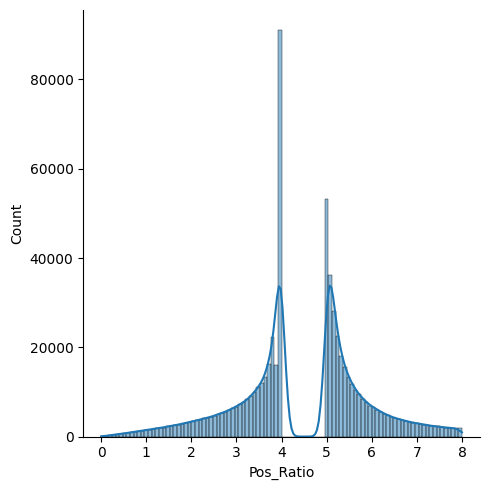

In [12]:
# ------------------ Distribución de todas las partículas ------------------

Total_Density = Partic_DF.copy()

Muestras = 100  # Número de muestras

sns.displot(Total_Density, x="Pos_Ratio",bins=Muestras, kde=True)
print(Total_Density["Pos_Ratio"].max())
plt.savefig(os.path.join(output_dir, "Ratial_Total_Dist.png"))

del Muestras

In [13]:
Total_Density = Partic_DF.copy()

Muestras = 50               # Número de muestras

# Calcular el tamaño de cada intervalo
interval_size_Int = r_1 / Muestras
interval_size_Ext = (r_2 - r_G) / Muestras

# Crear una lista de diccionarios para almacenar los resultados
resultados_Int = []
resultados_Ext = []

# Calcular el rango de valores para cada intervalo y almacenarlos en la lista de resultados
for i in range(Muestras):
    inicio = i * interval_size_Int
    fin = (i + 1) * interval_size_Int
    resultados_Int.append({'Intervalo': f'({inicio}, {fin})', 'Inicio': inicio, 'Fin': fin})

for i in range(Muestras):
    inicio = i * interval_size_Ext + r_G
    fin = (i + 1) * interval_size_Ext + r_G
    resultados_Ext.append({'Intervalo': f'({inicio}, {fin})', 'Inicio': inicio, 'Fin': fin})
    
    
# Crear el DataFrame a partir de la lista de resultados
Total_Density = pd.DataFrame(resultados_Int)

# Crear un DataFrame para los resultados externos
resultados_Ext_df = pd.DataFrame(resultados_Ext)

# Concatenar los DataFrames usando la función concat
Total_Density = pd.concat([Total_Density, resultados_Ext_df], ignore_index=True)

# Crear una lista para almacenar los contadores de densidad de carga
densidad_carga = [0] * (Muestras*2)  # Agregar uno para el resultado externo

# Iterar sobre cada valor en la columna Pos_Ratio de Particle_DF
for valor in Partic_DF['Pos_Ratio']:
    # Verificar en qué intervalo se encuentra el valor
    for i in range(Muestras):
        inicio_Int = i * interval_size_Int
        fin_Int = (i + 1) * interval_size_Int
        inicio_Ext = (i * interval_size_Ext) + r_G
        fin_Ext = ((i + 1) * interval_size_Ext) + r_G
        
        if inicio_Int <= valor < fin_Int:
            # Incrementar el contador correspondiente al intervalo
            densidad_carga[i] += 1
            break  # Romper el bucle una vez que se ha encontrado el intervalo
        elif inicio_Ext <= valor < fin_Ext:
            # Incrementar el contador correspondiente al intervalo
            densidad_carga[i+(Muestras)] += 1
            break  # Romper el bucle una vez que se ha encontrado el intervalo
        
# Crear una columna "Densidad_Carga" en el DataFrame df_resultados
Total_Density['Count'] = densidad_carga


# Crear la columna "Q" en el DataFrame Total_Density
Total_Density['Q'] = Q_p

# Aplicar la condición para ajustar los valores de la columna "Q"
Total_Density.loc[Total_Density['Fin'] > r_1, 'Q'] = Q_n

print("La suma de Partículas es igual a ",Total_Density["Count"].sum())


del Muestras,interval_size_Int,interval_size_Ext,resultados_Int,resultados_Ext,i,inicio
del fin,densidad_carga,valor,inicio_Int,fin_Int,inicio_Ext,fin_Ext 

La suma de Partículas es igual a  650998


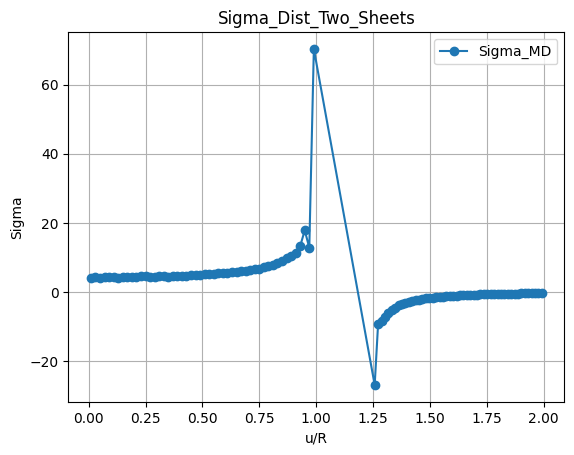

In [14]:
# SigmaTwoSheets=pd.read_csv(r"E:\Cristian\1. Molecular Dinamics\2. Python Projects\3. Jupiter Code\92. SigmaTwoSheets.dat", sep='\t')

Total_Density['u/R'] = ((Total_Density['Fin']+Total_Density['Inicio'])/2)/r_1

# Crear la columna "Q" en el DataFrame Total_Density
Total_Density['Q'] = Q_p

# Aplicar la condición para ajustar los valores de la columna "Q"
Total_Density.loc[Total_Density['Fin'] > r_1, 'Q'] = Q_n

Total_Density['Sigma'] = (Total_Density['Count'] * Total_Density['Q']) / (np.pi * ((Total_Density['Fin']**2)-(Total_Density['Inicio']**2)))
Total_Density['Sigma'] = Total_Density['Sigma'] / Step_Scale

# area_y1 = np.trapz(Total_Density['Sigma'], Total_Density['u/R'])
# area_y2 = np.trapz(SigmaTwoSheets["Sigma"], SigmaTwoSheets["u/R"])

# Factor_Esc = area_y2 / area_y1

# Total_Density['Sigma'] = Total_Density['Sigma'] * Factor_Esc

plt.plot(Total_Density["u/R"], Total_Density["Sigma"], label="Sigma_MD", marker='o', linestyle='-')
# plt.plot(SigmaTwoSheets["u/R"], SigmaTwoSheets["Sigma"], label="Sigma_MM", marker='o', linestyle='-')
plt.xlabel("u/R")  # Etiqueta del eje x
plt.ylabel("Sigma")
plt.title("Sigma_Dist_Two_Sheets")
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig(os.path.join(output_dir, "Sigma_Dist_Comp_All.png"))

# del area_y1,area_y2,Factor_Esc

325499
325499


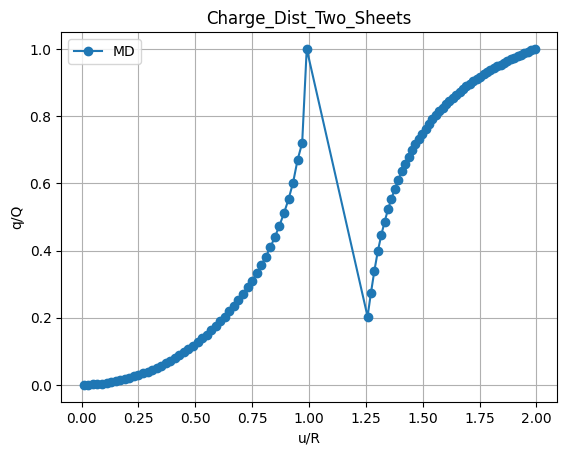

In [15]:
# TwoSheets_Data = pd.read_csv(r"E:\Cristian\1. Molecular Dinamics\2. Python Projects\3. Jupiter Code\93. ChargeTwoSheets.dat", sep='\t')

# Crear una lista para almacenar las sumas acumuladas
q_comulate = []
acumulado = 0
encontrado_r1 = False

# Recorrer el DataFrame Total_Density y calcular las sumas acumuladas
for index, row in Total_Density.iterrows():
    if row['Fin'] == r_1:
        acumulado += row['Count']
        q_comulate.append(acumulado)
        encontrado_r1 = True
        acumulado = 0
    elif encontrado_r1:
        acumulado += row['Count']
        q_comulate.append(acumulado)
    else:
        acumulado += row['Count']
        q_comulate.append(acumulado)
        
# Agregar la lista como columna "q_Comulate" al DataFrame Total_Density
Total_Density['q_Comulate'] = q_comulate

# Encontrar la suma de los valores de "Count" donde "Fin" es menor a r_1 y asignarla a Val1
Val1 = Total_Density.loc[Total_Density['Fin'] <= r_1, 'Count'].sum()

# Encontrar la suma de los valores de "Count" donde "Fin" es mayor a r_1 y asignarla a Val2
Val2 = Total_Density.loc[Total_Density['Fin']  > r_1, 'Count'].sum()

print(Val1)
print(Val2)

Total_Density['q/Q'] = Total_Density['q_Comulate']

for index, row in Total_Density.iterrows():
    if row['Fin'] <= r_1:
        Total_Density.loc[index, 'q/Q'] /= Val1
    elif row['Fin'] > r_1:
        Total_Density.loc[index, 'q/Q'] /= Val2

plt.plot(Total_Density["u/R"], Total_Density["q/Q"], label="MD", marker='o', linestyle='-')
# plt.plot(TwoSheets_Data["u/R"], TwoSheets_Data["q/Q"], label="MoM", marker='o', linestyle='-')
plt.xlabel("u/R")  # Etiqueta del eje x
plt.ylabel("q/Q")
plt.title("Charge_Dist_Two_Sheets")
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig(os.path.join(output_dir, "Charge_Dist_Total.png"))

ruta_Total_Density = os.path.join(output_dir, "91. Sigma_&_Charge_MD.csv")
Total_Density.to_csv(ruta_Total_Density, sep='\t', index=False)

del q_comulate,acumulado,encontrado_r1,index,row,Val1,Val2

0.0001
0.001
0.002
0.05
0.1
0.2
1.0


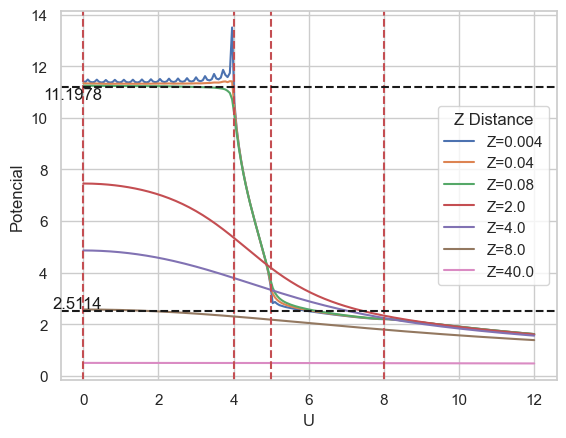

In [16]:
import scipy.special as sps

Muestras = 50               # Número de muestras

# Calcular el tamaño de cada intervalo
interval_size_Int = r_1 / Muestras
interval_size_Ext = (r_2 - r_G) / Muestras

Total_Density['Center'] = (Total_Density['Inicio'] + Total_Density['Fin'])/2

def generar_numeros_equidistantes(N, inicio, fin):
    if N <= 1:
        return [inicio]

    paso = (fin - inicio) / (N - 1)  # Calcula el paso entre los números
    numeros = []

    for i in range(N):
        valor = inicio + i * paso
        numeros.append(valor)

    return numeros

def Delta_U(n):
    if n < Muestras:
        return interval_size_Int
    else:
        return interval_size_Ext

def Center_U(n):
    return Total_Density.loc[n, "Center"]

def Sigma_U(n):
    return Total_Density.loc[n, "Sigma"]

# Ejemplo de una función que calcula el potencial (debes definir la tuya)
def Potencial_Esp(valor_u, Z):
    
    Const = 1/(4*np.pi*e0)
    
    POTENCIAL = 0
    
    for i in range(2*Muestras):
        Density_u = Sigma_U(i)
        Center_u = Center_U(i)
        Delta_u = Delta_U(i)
        
        Dif_2 = (valor_u-Center_u)**2
        
        POTENCIAL += (Density_u * Center_u * Delta_u) * (4/(np.sqrt((Dif_2)+(Z**2)))) * sps.ellipk(-4*((valor_u*Center_u)/((Dif_2)+(Z**2))))
    
    return Const*POTENCIAL

U_Total = 201

Potencial_DF = pd.DataFrame({'U': generar_numeros_equidistantes(U_Total,0,1.5*r_2)})

# Lista de valores de Z que deseas graficar
valores_Z = [r_1/1000,r_1/100,r_1/50,r_1/2,r_1,2*r_1,10*r_1]

# Crear un gráfico de dispersión para cada valor de Z
sns.set(style="whitegrid")  # Establece el estilo del gráfico



for Z in valores_Z:
    print(Z/max(valores_Z))
    columna_potencial = f'Potencial_{Z}'
    Potencial_DF[columna_potencial] = Potencial_DF['U'].apply(Potencial_Esp, Z=Z)
    # Potencial_DF[columna_potencial] = Potencial_DF[columna_potencial]/len(System_DF)
    sns.lineplot(data=Potencial_DF, x='U', y=columna_potencial, label=f'Z={Z}')

# Personaliza el gráfico (títulos y etiquetas)
# plt.title('Gráfico de Potencial en función de U para diferentes valores de Z')
plt.xlabel('U')
plt.ylabel('Potencial')

# Agrega una leyenda
plt.legend(title='Z Distance')

# Dibuja dos líneas verticales en el eje X
plt.axvline(x=  0, color='r', linestyle='--')
plt.axvline(x=r_1, color='r', linestyle='--')
plt.axvline(x=r_G, color='r', linestyle='--')
plt.axvline(x=r_2, color='r', linestyle='--')

# plt.axhline(y=-0.35, color='r', linestyle='--', label='Zona A')

# Rellena el área entre las líneas verticales
# plt.fill_betweenx([0, max(Potencial_DF['Potencial_0.1'])], r_G, r_2, color='gray', alpha=0.5, label='Ext_Disc')

Prom_G = Potencial_DF[(Potencial_DF['U'] > r_G) & (Potencial_DF['U'] < r_2)]['Potencial_0.08'].mean()
Prom_r1 = Potencial_DF[Potencial_DF['U'] < r_1]['Potencial_0.08'].mean()

plt.axhline(y=Prom_G, color='k', linestyle='--', label=f'Promedio_G={Prom_G:.4f}')
plt.axhline(y=Prom_r1, color='k', linestyle='--', label=f'Promedio_r1={Prom_r1:.4f}')

# Agrega etiquetas para los valores medios en la gráfica
plt.text(0.5, Prom_G, f'{Prom_G:.4f}', va='bottom', ha='right', color='k')
plt.text(0.5, Prom_r1, f'{Prom_r1:.4f}', va='top', ha='right', color='k')



# plt.show()
plt.savefig(os.path.join(output_dir, "Potencial.png"))

ruta_Potencial = os.path.join(output_dir, "92. Potencial_MD.csv")
Potencial_DF.to_csv(ruta_Potencial, sep='\t', index=False)

del Z,U_Total,valores_Z,columna_potencial,Prom_G ,Prom_r1,Muestras,interval_size_Int,interval_size_Ext

In [17]:
POT_M = System_DF['Pot_Energy'].mean()
KEE_M = System_DF['Ke_T'].mean()

COVARIANZA = System_DF['Ke_T'].cov(System_DF['Pot_Energy'])

print("Covarianza = ",COVARIANZA)

Covarianza =  -1.645229268331269


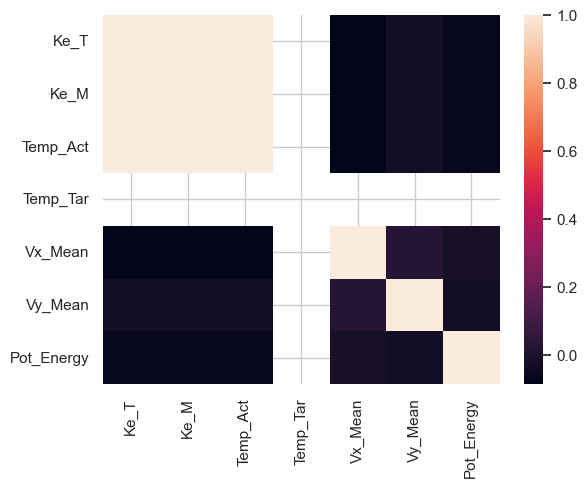

In [18]:
SYSTEM_COPY = System_DF.copy()

SYSTEM_COPY = SYSTEM_COPY.drop(['Step'], axis=1)

sns.heatmap(SYSTEM_COPY.corr());

In [19]:
Mass = float(Simulation_Values.loc[Simulation_Values['Variable'] == 'm', 'Valor'].iloc[0])

# Crear vectores bidimensionales de posición y velocidad
position_vector = np.column_stack((Partic_DF['X_Pos'], Partic_DF['Y_Pos']))
velocity_vector = np.column_stack((Partic_DF['Vel_X'], Partic_DF['Vel_Y']))

# Calcular el producto cruz
angular_moment = np.cross(position_vector, Mass * velocity_vector)

# Asignar los resultados a una nueva columna en el DataFrame
Partic_DF['Partic_Angular_Moment'] = angular_moment

# Primero, agrupa los datos por el valor en la columna 'Step' y calcula la suma de 'Partic_Angular_Moment' para cada grupo
result = Partic_DF.groupby('Step')['Partic_Angular_Moment'].sum().reset_index()

# Renombra la columna resultante a 'Step_Angular_Moment'
result = result.rename(columns={'Partic_Angular_Moment': 'Step_Angular_Moment'})

# Ahora, combina este resultado con tu DataFrame original utilizando la columna 'Step' como clave
Partic_DF = pd.merge(Partic_DF, result, on='Step')

# El DataFrame Partic_DF ahora contiene la columna 'Step_Angular_Moment' con la suma de 'Partic_Angular_Moment' para cada paso

del position_vector,velocity_vector,angular_moment,result

In [20]:
# Obtiene los valores únicos en la columna 'Step_Angular_Moment'
unique_values = Partic_DF['Step_Angular_Moment'].unique()

# Imprime la cantidad total de valores únicos
print("Cantidad total de valores únicos en la columna 'Step_Angular_Moment':", len(unique_values))

del unique_values

Cantidad total de valores únicos en la columna 'Step_Angular_Moment': 651


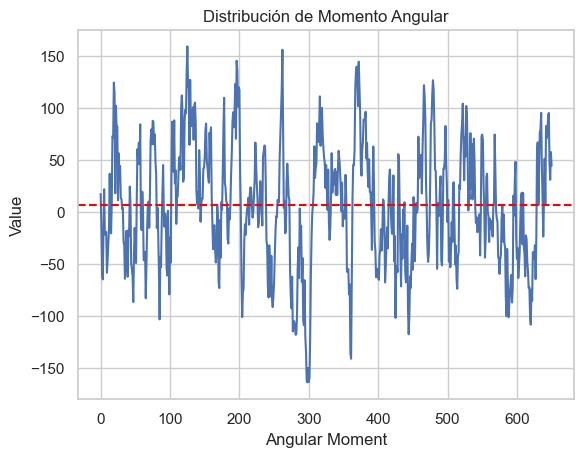

6.653746418283297


In [21]:
def Plot_Dist2(df, colum, line_value, name):

    # Group the DataFrame by the 'Step' column
    grouped_df = df.groupby('Step')

    # Calculate the mean of the 'Value' column for each group
    mean_values = grouped_df[colum].mean().values

    plt.close("all")  # Cerrar todas las figuras anteriores
    num_steps = len(mean_values)
    plt.plot(range(num_steps), mean_values)
    plt.xlabel('Angular Moment')
    plt.ylabel('Value')
    plt.title('Distribución de Momento Angular')
    plt.axhline(y=line_value, color='red', linestyle='--')
    plt.savefig(os.path.join(output_dir, name))
    plt.show()
    
Plot_Dist2(Partic_DF,'Step_Angular_Moment', Partic_DF['Step_Angular_Moment'].mean(), "Step_Angular_Moment.png")
print(Partic_DF['Step_Angular_Moment'].mean())
    

In [22]:
from numpy import linalg as LA

Last_Step_DF = Partic_DF[Partic_DF['Step'] == Partic_DF['Step'].max()]

X = Last_Step_DF['X_Pos']
Y = Last_Step_DF['Y_Pos']

IDEAL = False

def magnitude(vector) : 
    return LA.norm(vector)

def q(n) :
    if IDEAL == True:
      return 0
    else: 
      if n < N/2: 
        return Q_p # n will start at zero
      else : 
        return Q_n

def Coulomb_Force_Cal (x,y):
  
  F = []

  rVector = np.column_stack((x,y)) #position vector

  Conts = 1/(4*np.pi*e0)

  for i in range(0, int(N)):
    Sum = 0
    Qi = q(i)
    for n in range(0, int(N)) :        
      if n != i :
        r12 = magnitude(rVector[n]-rVector[i])
        Sum = Sum+((q(n)*(rVector[i]-rVector[n]))/(r12**3))
        # print("Partícula: ",n," Sum: ", Sum)
    
    F.append(Conts*Qi*Sum)

  return F

def Coulomb_Force_Cal2(X, Y):
  global N
  
  N=int(N)
  
  X=np.array(X)
  Y=np.array(Y)
  
  k_e = 1/(4*np.pi*e0)

  # Crea una matriz de cargas utilizando la función q(n)
  cargas = np.array([q(n) for n in range(int(N))])

  # Crea matrices de diferencias de posiciones
  dx = X.reshape(N, 1) - X
  dy = Y.reshape(N, 1) - Y

  # Calcula las distancias al cuadrado y evita la división por cero
  distancia_cuadrado = np.maximum(dx**2 + dy**2, 1e-12)

  # Calcula las fuerzas de Coulomb
  fuerzas = (k_e * cargas.reshape(N, 1) * cargas) / distancia_cuadrado

  # Elimina la diagonal (autointeracción) y suma las fuerzas en el eje Y y X
  np.fill_diagonal(fuerzas, 0)
  fuerzas_x = np.sum(fuerzas * (dx / np.sqrt(distancia_cuadrado)), axis=1)
  fuerzas_y = np.sum(fuerzas * (dy / np.sqrt(distancia_cuadrado)), axis=1)
  
  return np.column_stack((fuerzas_x, fuerzas_y))

# Crear un DataFrame para almacenar las fuerzas
forces_df = pd.DataFrame()

Forces1 = np.array(Coulomb_Force_Cal(X, Y))
Forces2 = np.array(Coulomb_Force_Cal2(X, Y))

forces_df['X_c1'] = Forces1[:, 0]  # Componente X
forces_df['X_c2'] = Forces2[:, 0]  # Componente X

forces_df['Y_c1'] = Forces1[:, 1]  # Componente Y
forces_df['Y_c2'] = Forces2[:, 1]  # Componente Y

# Imprimir el DataFrame con las fuerzas
print(forces_df)

forces_df['X_c1'] = forces_df['X_c1'].round(9)
forces_df['X_c2'] = forces_df['X_c2'].round(9)

forces_df['Y_c1'] = forces_df['Y_c1'].round(9)
forces_df['Y_c2'] = forces_df['Y_c2'].round(9)

are_equal = forces_df['X_c1'].equals(forces_df['X_c2'])
print(are_equal)

are_equal = forces_df['Y_c1'].equals(forces_df['Y_c2'])
print(are_equal)

         X_c1      X_c2      Y_c1      Y_c2
0    1.265211  1.265211 -1.461787 -1.461787
1   -1.076856 -1.076856  1.832480  1.832480
2    3.201256  3.201256 -2.694785 -2.694785
3   -0.745890 -0.745890  2.903437  2.903437
4   -0.500035 -0.500035  0.746337  0.746337
..        ...       ...       ...       ...
995  0.166406  0.166406  0.078440  0.078440
996 -0.162093 -0.162093 -0.383542 -0.383542
997 -0.317073 -0.317073 -0.409570 -0.409570
998 -0.484275 -0.484275 -0.388960 -0.388960
999 -0.295193 -0.295193  0.066455  0.066455

[1000 rows x 4 columns]
True
True
